In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vaibhao_handwritten_characters_path = kagglehub.dataset_download('vaibhao/handwritten-characters')
landlord_handwriting_recognition_path = kagglehub.dataset_download('landlord/handwriting-recognition')

print('Data source import complete.')


100%|██████████| 1.62G/1.62G [00:19<00:00, 91.6MB/s]

Extracting files...


100%|██████████| 1.26G/1.26G [00:22<00:00, 61.0MB/s]

Extracting files...


Data source import complete.


Handwritten text recognition by using segmentation and classification.

## Approach

* **Step1** :  Build a digit(0-9) + A-Z characters classifier using a CNN architecture.
* **Step2** :  Apply character segmentation for the handwritten word image.
* **Step3** :  Classify each segmented letter and then get the final word in the image.

In [3]:
!pip install imutils

In [4]:
!pip install --upgrade tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from tensorflow.keras.utils import to_categorical  # Import to_categorical for one-hot encoding
import os
import random
import cv2
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential  # Updated import path
from tensorflow.keras import optimizers         # Updated import path
from tensorflow.keras import backend as K       # Updated import path
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Flatten,
    MaxPooling2D,
    Dropout,
    Conv2D,
    BatchNormalization,
)


In [6]:

# Define the directory of the dataset
dir = os.path.join(vaibhao_handwritten_characters_path, 'Train')  # Updated path to the Kaggle dataset

train_data = []
img_size = 32
non_chars = ["#","$","&","@"]

# Loop through the directories in the 'Train' folder of the dataset
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir, i)

    # Loop through the image files in each sub-directory
    for j in os.listdir(sub_directory):
        count += 1
        if count > 4000:  # Limit the number of images to 4000
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)  # Read image in grayscale
        img = cv2.resize(img, (img_size, img_size))  # Resize image to specified size
        train_data.append([img, i])  # Append image data and corresponding label

print("Image data preparation complete.")

Image data preparation complete.


In [7]:
len(train_data)

140000

In [8]:
# Define the directory of the validation dataset
val_dir = os.path.join(vaibhao_handwritten_characters_path, 'Validation')  # Updated path to the Kaggle dataset

val_data = []
img_size = 32
non_chars = ["#","$","&","@"]

# Loop through the directories in the 'Validation' folder of the dataset
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir, i)

    # Loop through the image files in each sub-directory
    for j in os.listdir(sub_directory):
        count += 1
        if count > 1000:  # Limit the number of images to 1000
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)  # Read image in grayscale
        img = cv2.resize(img, (img_size, img_size))  # Resize image to specified size
        val_data.append([img, i])  # Append image data and corresponding label

print("Validation data preparation complete.")

Validation data preparation complete.


In [9]:
len(val_data)

15209

In [10]:
random.shuffle(train_data)
random.shuffle(val_data)

In [11]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [12]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [13]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [14]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [15]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [16]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [17]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,851 (636.14 KB)

 Trainable params: 162,851 (636.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [21]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.6989 - loss: 1.0107 - val_accuracy: 0.8937 - val_loss: 0.3343
Epoch 2/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8781 - loss: 0.3596 - val_accuracy: 0.8807 - val_loss: 0.3286
Epoch 3/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8953 - loss: 0.3082 - val_accuracy: 0.8909 - val_loss: 0.2946
Epoch 4/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9032 - loss: 0.2788 - val_accuracy: 0.9059 - val_loss: 0.2657
Epoch 5/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9097 - loss: 0.2568 - val_accuracy: 0.9053 - val_loss: 0.2520
Epoch 6/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9132 - loss: 0.2436 - val_accuracy: 0.9016 - val_loss: 0.2511
Epoch 7/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9185 - loss: 0.2313 - val_accuracy: 0.9164 - val_loss: 0.2446
Epoch 8/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9196 - loss: 0

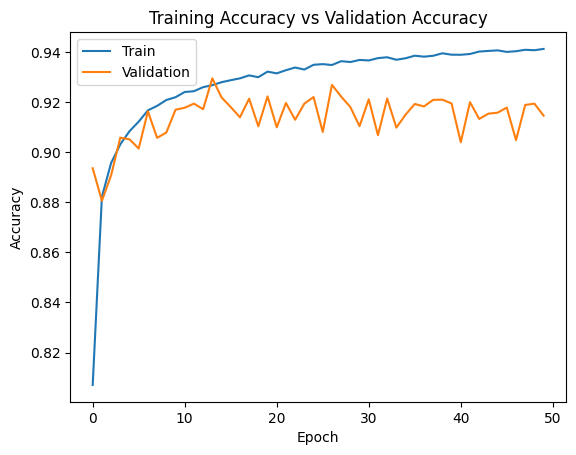

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

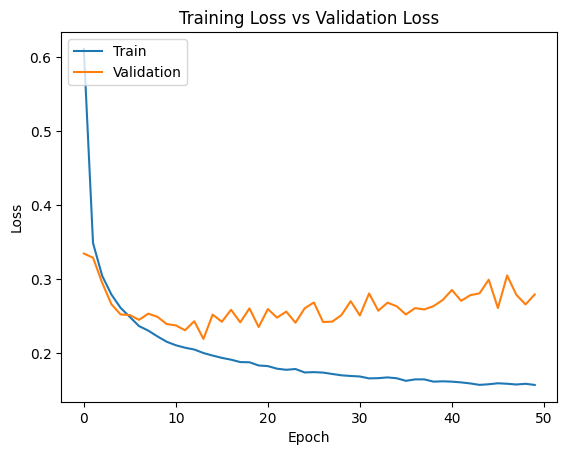

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word.

In [24]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [25]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [26]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
BTNE5


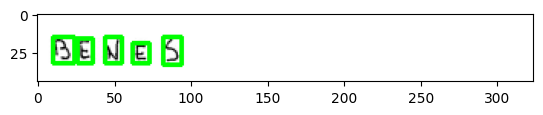

In [27]:
# Define the directory path for your image (update to correct dataset folder)
image_path = os.path.join(landlord_handwriting_recognition_path, 'train_v2', 'train', 'TRAIN_00003.jpg')

# Function to extract letters and words from image (assuming 'get_letters' and 'get_word' are defined)
letter, image = get_letters(image_path)
word = get_word(letter)

# Print the word and display the image
print(word)
plt.imshow(image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
LIL00


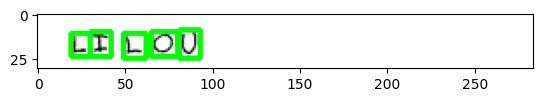

In [28]:
image_path = os.path.join(landlord_handwriting_recognition_path, 'train_v2', 'train', 'TRAIN_00023.jpg')

# Function to extract letters and words from image (assuming 'get_letters' and 'get_word' are defined)
letter, image = get_letters(image_path)
word = get_word(letter)

# Print the word and display the image
print(word)
plt.imshow(image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
JAFFFIX


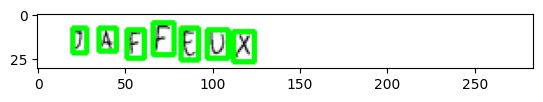

In [29]:
image_path = os.path.join(landlord_handwriting_recognition_path, 'train_v2', 'train', 'TRAIN_00030.jpg')

# Function to extract letters and words from image (assuming 'get_letters' and 'get_word' are defined)
letter, image = get_letters(image_path)
word = get_word(letter)

# Print the word and display the image
print(word)
plt.imshow(image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8UPP


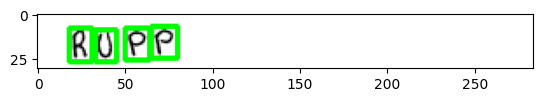

In [30]:
image_path = os.path.join(landlord_handwriting_recognition_path, 'validation_v2', 'validation', 'VALIDATION_0005.jpg')

# Function to extract letters and words from image (assuming 'get_letters' and 'get_word' are defined)
letter, image = get_letters(image_path)
word = get_word(letter)

# Print the word and display the image
print(word)
plt.imshow(image)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
VA1ENTJNE


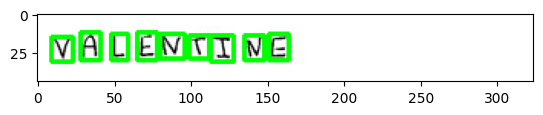

In [31]:
image_path = os.path.join(landlord_handwriting_recognition_path, 'test_v2', 'test', 'TEST_0007.jpg')

# Function to extract letters and words from the image (assuming 'get_letters' and 'get_word' are defined)
letter, image = get_letters(image_path)
word = get_word(letter)

# Print the word and display the image
print(word)
plt.imshow(image)
plt.show()

In [32]:
# Save the model with a proper extension
model_save_path = '/content/sample_data/handwriting_recognition_model.h5'  # Path with .h5 extension

# Save the model
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/sample_data/handwriting_recognition_model.h5


## Drawbacks
1. The recognition part is dependent on the contour detection code, so if the opencv library is not able to find the character contour, then this method will fail.
2. There could be a lot of variation in a single handwritten letter in terms of writing style, therefore a lot more examples are needed for training this model.
3. This model will not work for connected texts like a cursive handwritten word.

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
